EQE512 MATRIX METHODS IN STRUCTURAL ANALYSIS 

---
<h3 align="center"><font color = red >Week 11 - Frame Systems - Dynamic Properties </font></h3> 

<h4 align="center"><font color = blue >Dr. Ahmet Anıl Dindar (adindar@gtu.edu.tr)</font></h4> 
<h4 align="center"><font color = green >2020 Fall</font></h4> 


---

**Let's calculate the modal parameters of the given MDOF system**

<center><img src="./figures/15-EQE512-Week12-MDOF_Frame-Generic.PNG" width=25% , alignment = "center"> </img><\center>

This code is composed of two (2) main parts, namely 

1- Hand Calculation

2- OpenSeesPy

---

# Hand Calculations
<center><img src="./figures/15-EQE512-Week12-MDOF_Frame-Values.PNG" width=40% , alignment = "center"> </img><\center>

Material is C25 ($E = 32GPA$)

In [2]:
E = 32_000_000 # kN/m2

conc_weight = 25 # kN/m

UDL = 10 # kN/m

g = 9.81 # m7s2

# *********************** GEOMETRY
L , H1 , H2 , h_beam , b_beam, h_col , b_col = 5 , 3 , 3, 0.5 , 0.2 , 0.5 , 0.5 # m

**Mass Matrix**

In [4]:
# Load on beam
beam_load = UDL * L
beam_sw = ( h_beam * b_beam * L) * conc_weight

In [5]:
# Load on columns
column_sw = (h_col * b_col * H1) * conc_weight

In [11]:
# Mass of stories
M1 = ( 4 * column_sw / 2 + beam_load + beam_sw) / g
M1 = round( M1 ,2)

M2 = ( 2 * column_sw / 2 + beam_load + beam_sw) / g
M2 = round( M2 ,2)

In [12]:
# CONSTRUCT THE MASS MATRIX

import numpy as np

Mass_sys = np.array( [[ M1, 0] , [ 0, M2]])

print( Mass_sys)

[[10.19  0.  ]
 [ 0.    8.28]]


**Stiffness Matrix**

In [17]:
Mom_inertia = (b_col * h_col **3 ) / 12

K1 = 2 * (( 12 * E * Mom_inertia)/ ( H1**3))
K1 = round( K1 ,0)

K2 = 2 * (( 12 * E * Mom_inertia)/ ( H2**3))
K2 = round( K2 ,0)

In [18]:
# CONSTRUCT THE SYSTEM STIFFNESS MATRIX
K_sys = np.array( [[K1 + K2 , -K2],[-K2 , K2]])

print( K_sys)

[[ 296296. -148148.]
 [-148148.  148148.]]


**Calculation of the Natural Circular Frequencies**


<center><img src="./images/EQE512-Week11-NaturalFrequencies.png" width=25% , alignment = "center"> </img><\center>

In [20]:
# Calculation of natural circular frequencies

w2 = np.dot( np.linalg.inv( Mass_sys) , K_sys)

print( w2)

[[ 29077.13444553 -14538.56722277]
 [-17892.2705314   17892.2705314 ]]


In [21]:
# Calculaiton of mode shape vectors and values

V , D = np.linalg.eigh( w2)

In [22]:
V

array([ 4738.80587179, 42230.59910515])

In [23]:
D

array([[-0.59231397, -0.80570724],
       [-0.80570724,  0.59231397]])

In [24]:
w = [ item**0.5 for item in V]
w

[68.83898511590421, 205.50084940249792]

In [30]:
T = [ round( 2* (22/7) / item ,2)  for item in w]
for count, item in enumerate( T ) :
    print( f"{count+1} Mode Period is {item}sec.")

1 Mode Period is 0.09sec.
2 Mode Period is 0.03sec.


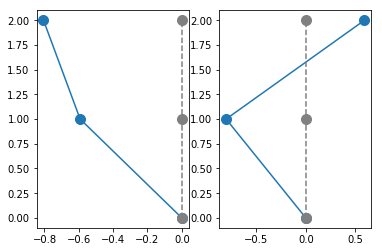

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

for mode_no , mode_shape in enumerate( D ):
    
    vector = list(D[:][mode_no])
    vector.insert(0,0)
    plt.subplot( 1,len(Mass_sys), mode_no + 1)
    plt.plot( vector , range(len(Mass_sys)+1) , "o-" , MS = 10)
    plt.plot( [0 for item in range( len(Mass_sys)+1) ], range(len(Mass_sys)+1) , "o--" , MS = 10 ,color="gray")


# OPENSEESPY


---

### <center>2- OpenSeesPy Modeling

In [23]:
# from openseespy import *

import openseespy.opensees as os

In [24]:
os.wipe() # Clear all OS values

In [25]:
os.model( "Basic", "-ndm", 2 , "-ndf", 3) # This is a 2D Frame

In [26]:
numBay = 1
numFloor = 2

In [27]:
bayWidht = 5.0 # m
storyHeight = 3.0 # m

In [29]:
E = 32000000 # kN/m2
massX = 5 * 2 # we'll discuss
M = 0. 
coordTransfer = "Linear" # Linear Transformation
massType = "-lMass" # Lumped mass

In [30]:
beams = [ "B20X50" for item in range( numFloor)]
eColumn = [ "C50X50" for item in range( numFloor)]
iColumn = [ "C50X50" for item in range( numFloor)]

columns = [eColumn , iColumn , eColumn]

In [31]:
Section = { "C50X50" : [ 0.5 * .5 , (0.5*0.5**3)/12],
          "B20X50": [0.2*.5 , (.2*0.5**3)/12]}

In [32]:
Section

{'C50X50': [0.25, 0.005208333333333333],
 'B20X50': [0.1, 0.0020833333333333333]}

In [33]:
def ElasticBeamColum( eleTag, iNode, jNode, sectType, E, transfTag, M, massType) :
    
    prop = Section[sectType]
    Area = prop[0]
    I = prop[1]
    
    os.element( "elasticBeamColumn", eleTag ,iNode, jNode, Area, E , I , transfTag , "-mass", M, massType)

In [34]:
import numpy as np
axis_h = np.linspace( 0 , (numBay * bayWidht)  ,numBay+1)
axis_v = np.linspace( 0 , (numFloor * storyHeight)  ,numFloor+1)


In [35]:
node_no =  1
node_dict = {}
floorNo = 0
floorNodes = {}
nodes = []
for i in axis_v:
    floorNodes[floorNo] = []
    
    for j in axis_h:
        nodes.append(node_no)

        # OPENSEES COMMAND
        os.node( node_no , float(j) , float(i))
        
        node_dict[node_no] = [float(j) , float(i)]
        floorNodes[floorNo].append(node_no)
        
        
        node_no += 1
    floorNo += 1

In [36]:
for nodeNumber in floorNodes[0]:
    os.fix( nodeNumber , 1,1,1)

In [37]:
# Rigid Diaphram Assignment
floorNodes

{0: [1, 2], 1: [3, 4], 2: [5, 6]}

In [38]:
for key, value in floorNodes.items():
    for item in value[:]:
        if item == value[0]:
            os.mass( item , massX , 0.0000000001 , 0.0000000001 )
        else: 
            os.equalDOF( value[0] , item , 1)

In [39]:
os.geomTransf(coordTransfer, 1)
column_dict = {}
eleTag = 1 
for  j in range(0 , numBay + 1):
    end1 = j + 1
    end2 = end1 + numBay + 1
    thisColumn = columns[j]
    
    for i in range( 0 ,numFloor):
        secType = thisColumn[ i]
        ElasticBeamColum( eleTag, end1 , end2 , secType , E , 1, M , massType)
        column_dict[eleTag] = [end1, end2]
        end1 =end2
        end2 += numBay + 1

        
        eleTag += 1
        

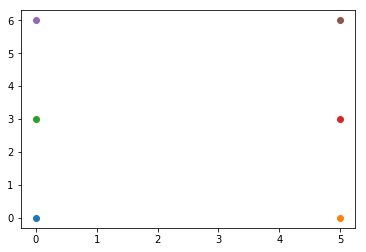

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

for key in node_dict.keys():
    plt.plot( node_dict[key][0] ,  node_dict[key][1] , "o"  )

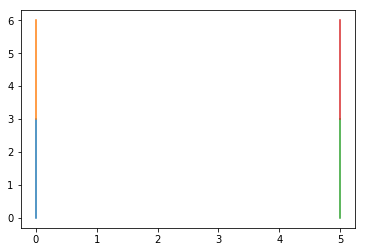

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

for key in column_dict.keys():
    plt.plot([ node_dict[column_dict[key][0]][0] ,node_dict[column_dict[key][1]][0]],
              [ node_dict[column_dict[key][0]][1] ,node_dict[column_dict[key][1]][1]]  )
    

In [42]:
beam_dict = {}
for j in range( 1 , numFloor +1):
    end1 = (numBay + 1) * j + 1
    end2 = end1+1
    secType = beams[j -1 ]
    for i in range(0, numBay):
        ElasticBeamColum(eleTag, end1, end2, secType, E, 1, M, massType) 
        beam_dict[eleTag] = [end1, end2]
        end1 = end2
        end2 = end1 + 1
        eleTag += 1

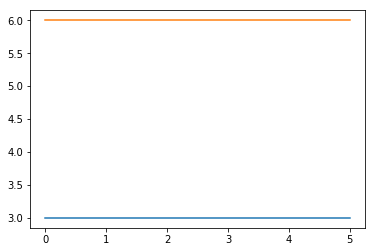

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

for key in beam_dict.keys():
    plt.plot([ node_dict[beam_dict[key][0]][0] ,node_dict[beam_dict[key][1]][0]],
              [ node_dict[beam_dict[key][0]][1] ,node_dict[beam_dict[key][1]][1]]  )
    

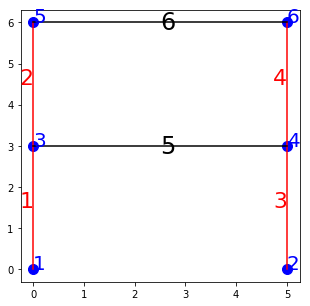

In [44]:
plt.figure(figsize= (5,5))


for key in node_dict.keys():
    plt.plot( node_dict[key][0] ,  node_dict[key][1] , "o" , MS = 10 , color="blue")
    plt.text(node_dict[key][0] ,  node_dict[key][1] , key , fontsize=20 , color="blue" )
    
for key in column_dict.keys():
    plt.plot([ node_dict[column_dict[key][0]][0] ,node_dict[column_dict[key][1]][0]],
              [ node_dict[column_dict[key][0]][1] ,node_dict[column_dict[key][1]][1]]  
            , color="red")
    plt.text(0.5*( node_dict[column_dict[key][0]][0] + node_dict[column_dict[key][1]][0]),
             0.5*(node_dict[column_dict[key][0]][1] + node_dict[column_dict[key][1]][1]), key , fontsize=22 ,color="r" , horizontalalignment="right")
    
for key in beam_dict.keys():
    plt.plot([ node_dict[beam_dict[key][0]][0] ,node_dict[beam_dict[key][1]][0]],
              [ node_dict[beam_dict[key][0]][1] ,node_dict[beam_dict[key][1]][1]] 
            , color="k")
    plt.text(0.5*( node_dict[beam_dict[key][0]][0] + node_dict[beam_dict[key][1]][0]),
             0.5*(node_dict[beam_dict[key][0]][1] + node_dict[beam_dict[key][1]][1]), key , fontsize=24 , color = "k" , verticalalignment="center")
    

In [45]:
numEigen = 2 
eigenValues = os.eigen( numEigen)

In [46]:
eigenValues

[1422.5997276161331, 23907.01437626409]

In [55]:
T_ospy = [ round( 2* (22/7) / item ,5)  for item in eigenValues]
for count, item in enumerate( T_ospy ) :
    print( f"{count+1} Mode Period is {item}sec.")

1 Mode Period is 0.00442sec.
2 Mode Period is 0.00026sec.


In [50]:
T_ospy

[0.00442, 0.00026]

**=> It seems the values are different. Why?**

---

**NEXT WEEK**

<table >
<tr>
<td>
<img src="http://worshiphousemedia.s3.amazonaws.com/images/main/s/st/bnt/st/seeyounextweek1.jpg" width="40%">
</td>
<td align="left"><strong style="font-size: 20px;">
The topics for the next week 
<br><br>

1- Assignment : 4
    
2- System behavior
<br><br>

<br>
</td>
</tr>
</table>